In [1]:
import sys
import h5py
import numpy as np
import healpy as hp
import tensorflow as tf
import random as python_random
import nnhealpix.layers
import matplotlib.pyplot as plt
from tensorflow.keras import metrics
import keras
import pandas as pd
import os, shutil
import useful_functions as uf
import NN_functions as nuf
from loss_functions import sigma_loss, sigma_f_loss, sigma2_loss,sigma_batch_loss,sigma_norm_loss,sigma_log_loss,mse_tau,mse_sigma

2023-06-26 14:56:57.224102: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-26 14:56:58.447980: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-26 14:56:58.448116: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-06-26 14:56:58.448132: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
#home_dir="/home/amorelli/r_estimate/B_maps_white_noise/results_22b_6_23/"
#load_dir='/home/amorelli/r_estimate/B_maps_white_noise/'
#to_load="test_data_r_0_001_t006_40.npz"
#to_load="test_data_r_0_006_t006_40.npz"

home_dir="/home/amorelli/E_foreground/25b_6_23/"
load_dir='/home/amorelli/E_foreground/' 
#to_load="test_data_r000_t001_013_411.npz"
to_load="test_data_d1s1_r000_t001_013_11.npz"

#loss_training=tf.keras.losses.MeanSquaredError()
loss_training=sigma_log_loss

checkpoint_dir=home_dir+"checkpoints"
last=76
normalize=True
test_model_folder="test_model"
n_output=2
metrics=[]
map_norm=True
nodes_per_layer=[48,128,128]
nside=16
drop=[0.2,0.4,0.3]
n_layers=1
n_inputs=2
use_drop=[False,True,True]

In [3]:
f=np.load(load_dir+to_load)
x_test=f["x_test"]
y_test=f["y_test"]
y_test,x_test=uf.unison_sorted_copies(y_test,x_test)

In [4]:
f_train=np.load(home_dir+"predictions.npz")
y_train=f_train["y_train"]
predictions_train=f_train["pred"]
norm=f_train["norm"]

In [5]:
model=nuf.build_network(n_inputs,nside,n_layers=n_layers,layer_nodes=nodes_per_layer,
                        num_output=n_output,use_normalization=[False,False,False],
                        use_drop=use_drop,drop=drop,
                        activation_dense="relu",kernel_initializer="glorot_uniform")
model.compile(loss=loss_training, optimizer=tf.optimizers.Adam(),metrics=metrics)

2023-06-26 14:57:02.133655: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-26 14:57:02.133968: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (coka.fe.infn.it): /proc/driver/nvidia/version does not exist
2023-06-26 14:57:02.135807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
files=os.listdir(checkpoint_dir)
for f in files:
    splitted = f.split("-")
    if int(splitted[2])==last:
        checkpoint_path=f
        break
print(checkpoint_path)
model.load_weights(checkpoint_dir+'/'+ checkpoint_path)

saved-weights-76-0.12939.hdf5


In [7]:
#print(files)

model = keras.models.load_model(
    home_dir+test_model_folder,  custom_objects={'loss_training' : loss_training, 'metrics' : metrics}, 
    compile=False
) #i restore the model from the test_model folder. I need to specify the custom objects and recompile the model with the custom
#objects, thus the metrics and the loss functions
model.compile(loss=loss_training,optimizer=tf.optimizers.Adam(), metrics=metrics)

In [8]:
#results=model.evaluate(x,y,verbose=2)
if map_norm:
    for i in range(len(x_test)):
        for j in range(n_inputs):
            t=x_test[i,:,j]
            x_test[i,:,j]=nuf.normalize_data(t,t)
predictions=model.predict(x_test)

2023-06-26 14:57:04.732231: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 245760000 exceeds 10% of free system memory.


313/313 [==============================] - 7s 20ms/step


In [9]:
if n_output>1:
    predictions=predictions[:,0]
    y_pred=predictions_train[:,0]
else:
    y_pred=predictions_train

In [10]:
if normalize:
    y_pred=nuf.denormalize_data(y_pred,norm)
    y_train=nuf.denormalize_data(y_train,norm)
    predictions=nuf.denormalize_data(predictions,norm)

In [11]:
#predictions=-predictions+0.01

tau_pred=predictions[:,0]
sigma_pred=np.abs(predictions[:,1])#*predictions[:,1]
tau_est=np.mean(tau_pred)
sigma_tau=np.std(tau_pred)**2
#sigma_tau=np.sum((tau_pred-0.06)**2)/10000
sigma_est=np.mean(sigma_pred)
counts_tau, bins_tau = np.histogram(tau_pred)
counts_sigma, bins_sigma = np.histogram(sigma_pred)

In [12]:
y_count, y_bias = uf.check_y(y_test)
b = predictions.flatten()-y_test.flatten()
bias = uf.running_average(b,y_count,y_bias)
pred = uf.running_average(predictions,y_count,y_bias)

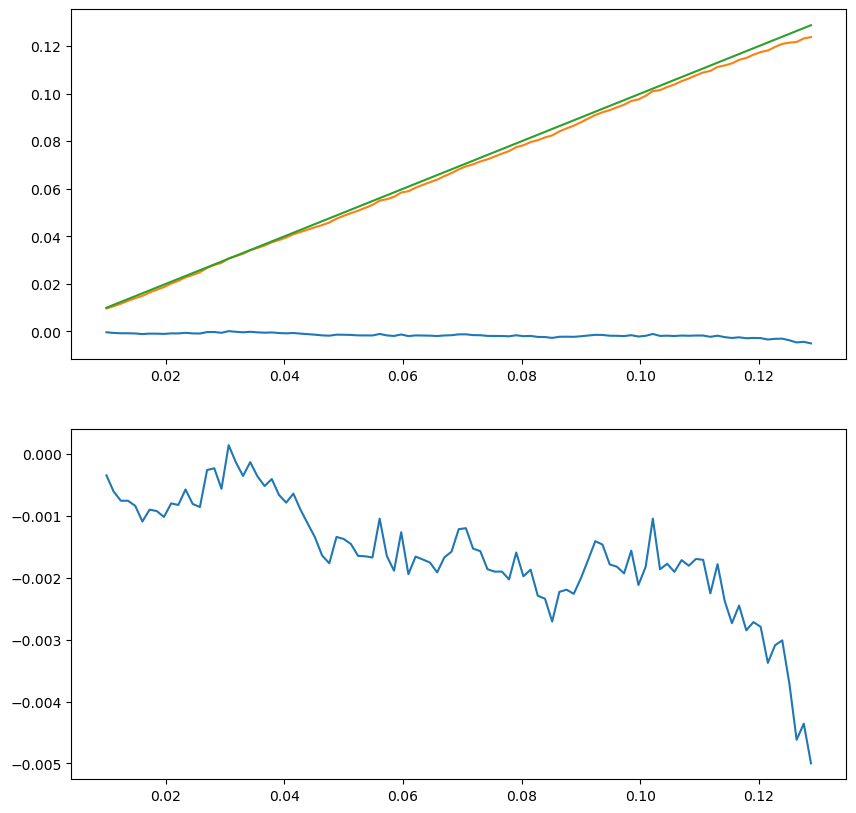

In [13]:
fig=plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
#print(y_bias)
plt.plot(y_bias,bias)
plt.plot(y_bias,pred)
plt.plot(y_bias,y_bias)
plt.subplot(2,1,2)
plt.plot(y_bias,bias)

In [14]:
y_train,y_pred = uf.unison_sorted_copies(y_train,y_pred)
y_count_train, y_bias_train = uf.check_y(y_train.flatten())
b_train = y_pred.flatten()-y_train.flatten()
bias_train = uf.running_average(b_train,y_count_train,y_bias_train)
pred_train = uf.running_average(y_pred,y_count_train,y_bias_train)

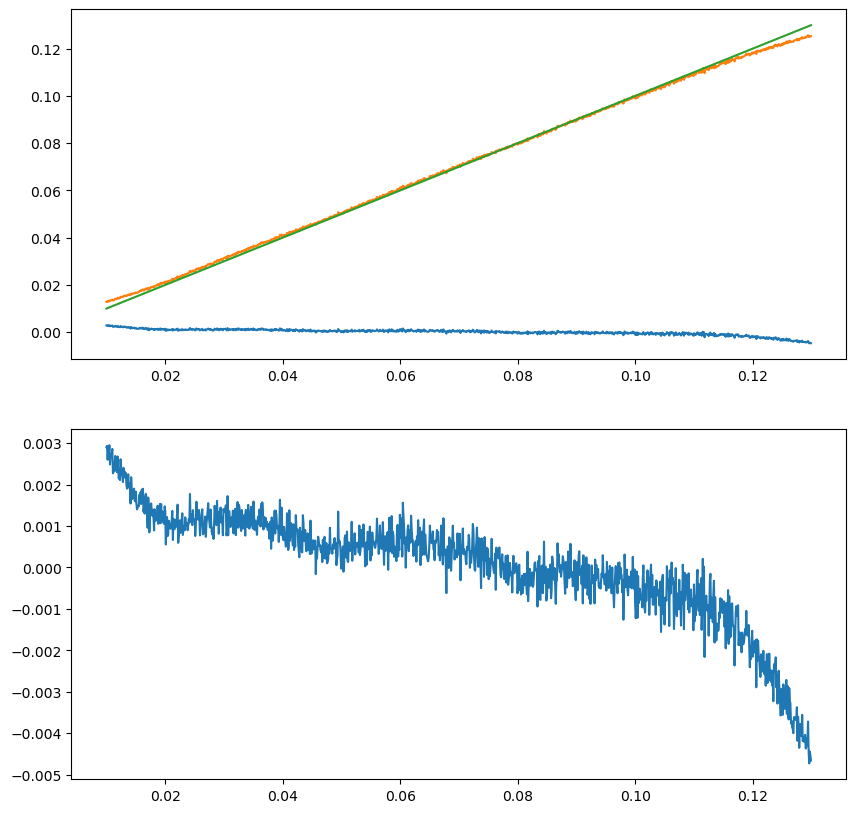

In [15]:
fig=plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(y_bias_train,bias_train)
plt.plot(y_bias_train,pred_train)
plt.plot(y_bias_train,y_bias_train)
plt.subplot(2,1,2)
plt.plot(y_bias_train,bias_train)